In [12]:
import symnum
import symnum.numpy as snp
import sympy
import numpy as np
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
from jax.lax import scan
import matplotlib.pyplot as plt
from jax.config import config
import mici
import arviz
import corner
config.update('jax_enable_x64', True)
config.update('jax_platform_name', 'cpu')

In [13]:
import sys
#sys.path.append('/Users/yugaiguchi/Library/Python/3.8/lib/python')
sys.path.append('/Users/yugaiguchi/Research/Development/GitHub/Dev_Hypo/Untitled')
import simsde

In [14]:
# x[0], x[1], x[2]: extended space (rough), x[3]: momentum, x[4]:position
# unit mass (M = 1), d_r = 3, d_X = 5. dim_bm = 3

def drift_position(x, θ):
    return snp.array([x[3]])

def drift_momentum(x, θ):
    λ_1, λ_2, λ_3, *_ = θ
    # the potential function q -> V(q) is assumed to be V(q) = q^2 /2 
    return snp.array([- x[4] + λ_1*x[0] + λ_2*x[1] + λ_3*x[2]])

def diff_coeff_rough(x, θ):
    *_, α_1, α_2, α_3, β = θ
    σ_1 = snp.sqrt(2*α_1/β)
    σ_2 = snp.sqrt(2*α_2/β) 
    σ_3 = snp.sqrt(2*α_3/β) 
    return snp.array([[σ_1, 0, 0], [0, σ_2, 0], [0, 0, σ_3]])

def drift_rough(x, θ):
    λ_1, λ_2, λ_3, α_1, α_2, α_3, *_ = θ
    return snp.array([
        - λ_1*x[3] - α_1*x[0], 
        - λ_2*x[3] - α_2*x[1], 
        - λ_3*x[3] - α_3*x[2]
    ])

def drift_smooth(x, θ):
    return snp.concatenate((drift_momentum(x, θ), drift_position(x, θ)))

def drift_func(x, θ):
    return snp.concatenate((drift_rough(x, θ), drift_smooth(x, θ)))

def diff_coeff(x, θ):
    return snp.concatenate((diff_coeff_rough(x, θ), snp.zeros((dim_x - dim_r, dim_w))), 0)

dim_x = 5
dim_s1 = 1
dim_s2 = 1
dim_r = 3
dim_θ = 7
dim_w = 3


Text(0.5, 0, 'Time')

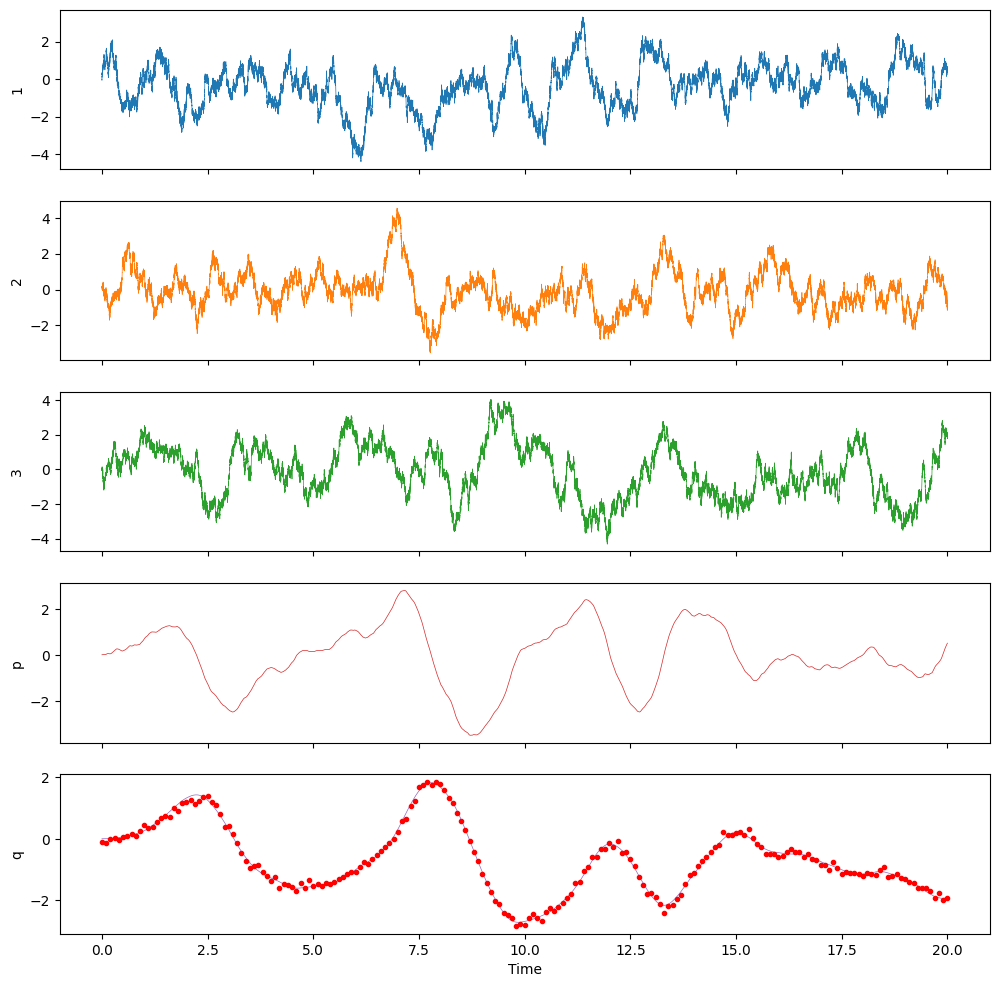

In [15]:
dim_u = 7
dim_v_0 = 3

def generate_θ(u):
    return jnp.array(
        [ 
            jnp.exp(u[0]),  # λ_1
            jnp.exp(u[1]),  # λ_2
            jnp.exp(u[2]),  # λ_3 
            jnp.exp(u[3]),  # α_1
            jnp.exp(u[4]),  # α_2
            jnp.exp(u[5]),  # α_3 
            jnp.exp(u[6]),  # β  
        ]
    )
    
def generate_x_0(θ, v_0):
    #return jnp.array([v_0[0]/θ[6], v_0[1]/θ[6], v_0[2]/θ[6], 0.00, 0.00])
    return jnp.array([0.00, 0.00, 0.00, 0.00, 0.00])
    
# assume we only observe the position (q_t)
def obs_func(x_seq):
    return (x_seq[:, 4])
    
def trace_func(state):
    θ = generate_θ(state.pos[:dim_u])
    x_0 = generate_x_0(θ, state.pos[dim_u:dim_u + dim_v_0])
    return {"λ_1": θ[0], "λ_2": θ[1], "λ_3": θ[2], "α_1": θ[3], "α_2": θ[4], "α_3": θ[5], "β": θ[6]}
    
def get_generate_x_seq_function(step_func, lower_bound=-500): # -500 is default

    @jit
    def generate_x_seq(x_0, θ, n_seq, t_seq):
        
        def compute_next_state(x, n_dt):
            n, dt = n_dt
            x = jnp.clip(x, lower_bound)
            x_next = lax.select(x > lower_bound, step_func(x, θ, n, dt), x)
            return x_next, x_next
        
        _, x_seq = scan(compute_next_state, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
        
        return jnp.concatenate((x_0[None], x_seq))
        
    return generate_x_seq

def get_posterior_density_functions(
    generate_θ, 
    generate_x_0, 
    generate_x_seq,
    obs_func,
    t_seq, 
    dim_u, 
    dim_v_0, 
    obs_noise_std, 
    obs_time_indices, 
    y_obs
):
        
    @jit
    def neg_log_posterior_density(q):
        u, v_0, n = q[:dim_u], q[dim_u:dim_u + dim_v_0], q[dim_u + dim_v_0:]
        n_seq = n.reshape((t_seq.shape[0] - 1, -1))
        θ = generate_θ(u)
        x_0 = generate_x_0(θ, v_0)
        x_seq = generate_x_seq(x_0, θ, n_seq, t_seq)
        y_mean = obs_func(x_seq[obs_time_indices])
        return (
            (((y_obs - y_mean) / obs_noise_std)**2).sum() / 2 
            + y_obs.size * jnp.log(obs_noise_std) 
            + (q **2).sum() / 2
        )
        
    @jit
    def grad_neg_log_posterior_density(q):
        val, grad = value_and_grad(neg_log_posterior_density)(q)
        return grad, val
        
    return {
        "neg_log_dens": lambda q: np.asarray(neg_log_posterior_density(q)), 
        "grad_neg_log_dens": lambda q: tuple(
            np.asarray(v) for v in grad_neg_log_posterior_density(q)
        )
    }
    
step_funcs_and_dim_n = {
    "euler_maruyama": (
        simsde.integrators.euler_maruyama_step(drift_func, diff_coeff),
        dim_r
    ),
    "local_gaussian_ii": (
        simsde.integrators.hypoelliptic_ii_local_gaussian_step(drift_func, drift_rough, drift_position, drift_momentum, diff_coeff_rough),
        3*dim_r
    )
}

generate_x_seq_functions = {
    key: get_generate_x_seq_function(
        symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)
    ) 
    for key, (step_func, dim_n) in step_funcs_and_dim_n.items()
}


dt_simulation = 1e-4
t_max = 20.
dt_observation = 0.1
t_seq_simulation = np.arange(int(t_max / dt_simulation) + 1) * dt_simulation
obs_time_indices_simulation = slice(None, None, int(dt_observation / dt_simulation))

simulation_method = "local_gaussian_ii"

rng_obs = np.random.default_rng(20230228)
obs_noise_std = 0.1
x_0_obs = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
θ_obs = np.array([1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.5])
n_seq_obs = rng_obs.standard_normal(
    (t_seq_simulation.shape[0] - 1, step_funcs_and_dim_n[simulation_method][1])
)
x_seq_obs = generate_x_seq_functions[simulation_method](
    x_0_obs, 
    θ_obs, 
    n_seq_obs,
    t_seq_simulation
)
y_obs_mean = obs_func(x_seq_obs[obs_time_indices_simulation])
y_obs = y_obs_mean + obs_noise_std * rng_obs.standard_normal(y_obs_mean.shape)

fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
# i: i-th extended variable (rough component), p: momentum, q: position 
labels = '123pq' 

for i, ax in enumerate(axes):
    ax.plot(t_seq_simulation, x_seq_obs[:, i], color=f'C{i}', lw=0.5)
    ax.set_ylabel(labels[i])
axes[4].plot(t_seq_simulation[obs_time_indices_simulation], y_obs, 'r.')
axes[-1].set_xlabel('Time')


euler_maruyama
0.05


Sampling stage: Adaptive warm up [02:13] > Main non-adaptive [01:46]

Chain 1/4: 100%|██████████|500/500 [00:01<00:00, 404.89it/s, n_step=1.00, accept_stat=0.00]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|500/500 [00:35<00:00, 14.28it/s, n_step=510., accept_stat=0.921]

Chain 3/4: 100%|██████████|500/500 [00:35<00:00, 14.28it/s, n_step=510., accept_stat=0.935]

Chain 4/4: 100%|██████████|500/500 [00:34<00:00, 14.32it/s, n_step=509., accept_stat=0.920]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ_1,2.548,3.025,0.240,7.742,1.489,1.147,7.0,1533.0,1.53
λ_2,0.664,0.480,0.098,1.532,0.142,0.103,11.0,5.0,1.30
λ_3,1.402,0.937,0.272,2.865,0.422,0.343,7.0,1563.0,1.53
α_1,1.377,1.751,0.060,4.083,0.319,0.228,11.0,5.0,1.30
α_2,1.567,1.820,0.049,3.839,0.055,0.039,1438.0,964.0,1.52
α_3,1.492,1.677,0.063,3.866,0.221,0.157,38.0,1139.0,1.08
β,0.631,0.187,0.272,0.925,0.041,0.030,24.0,1574.0,1.12


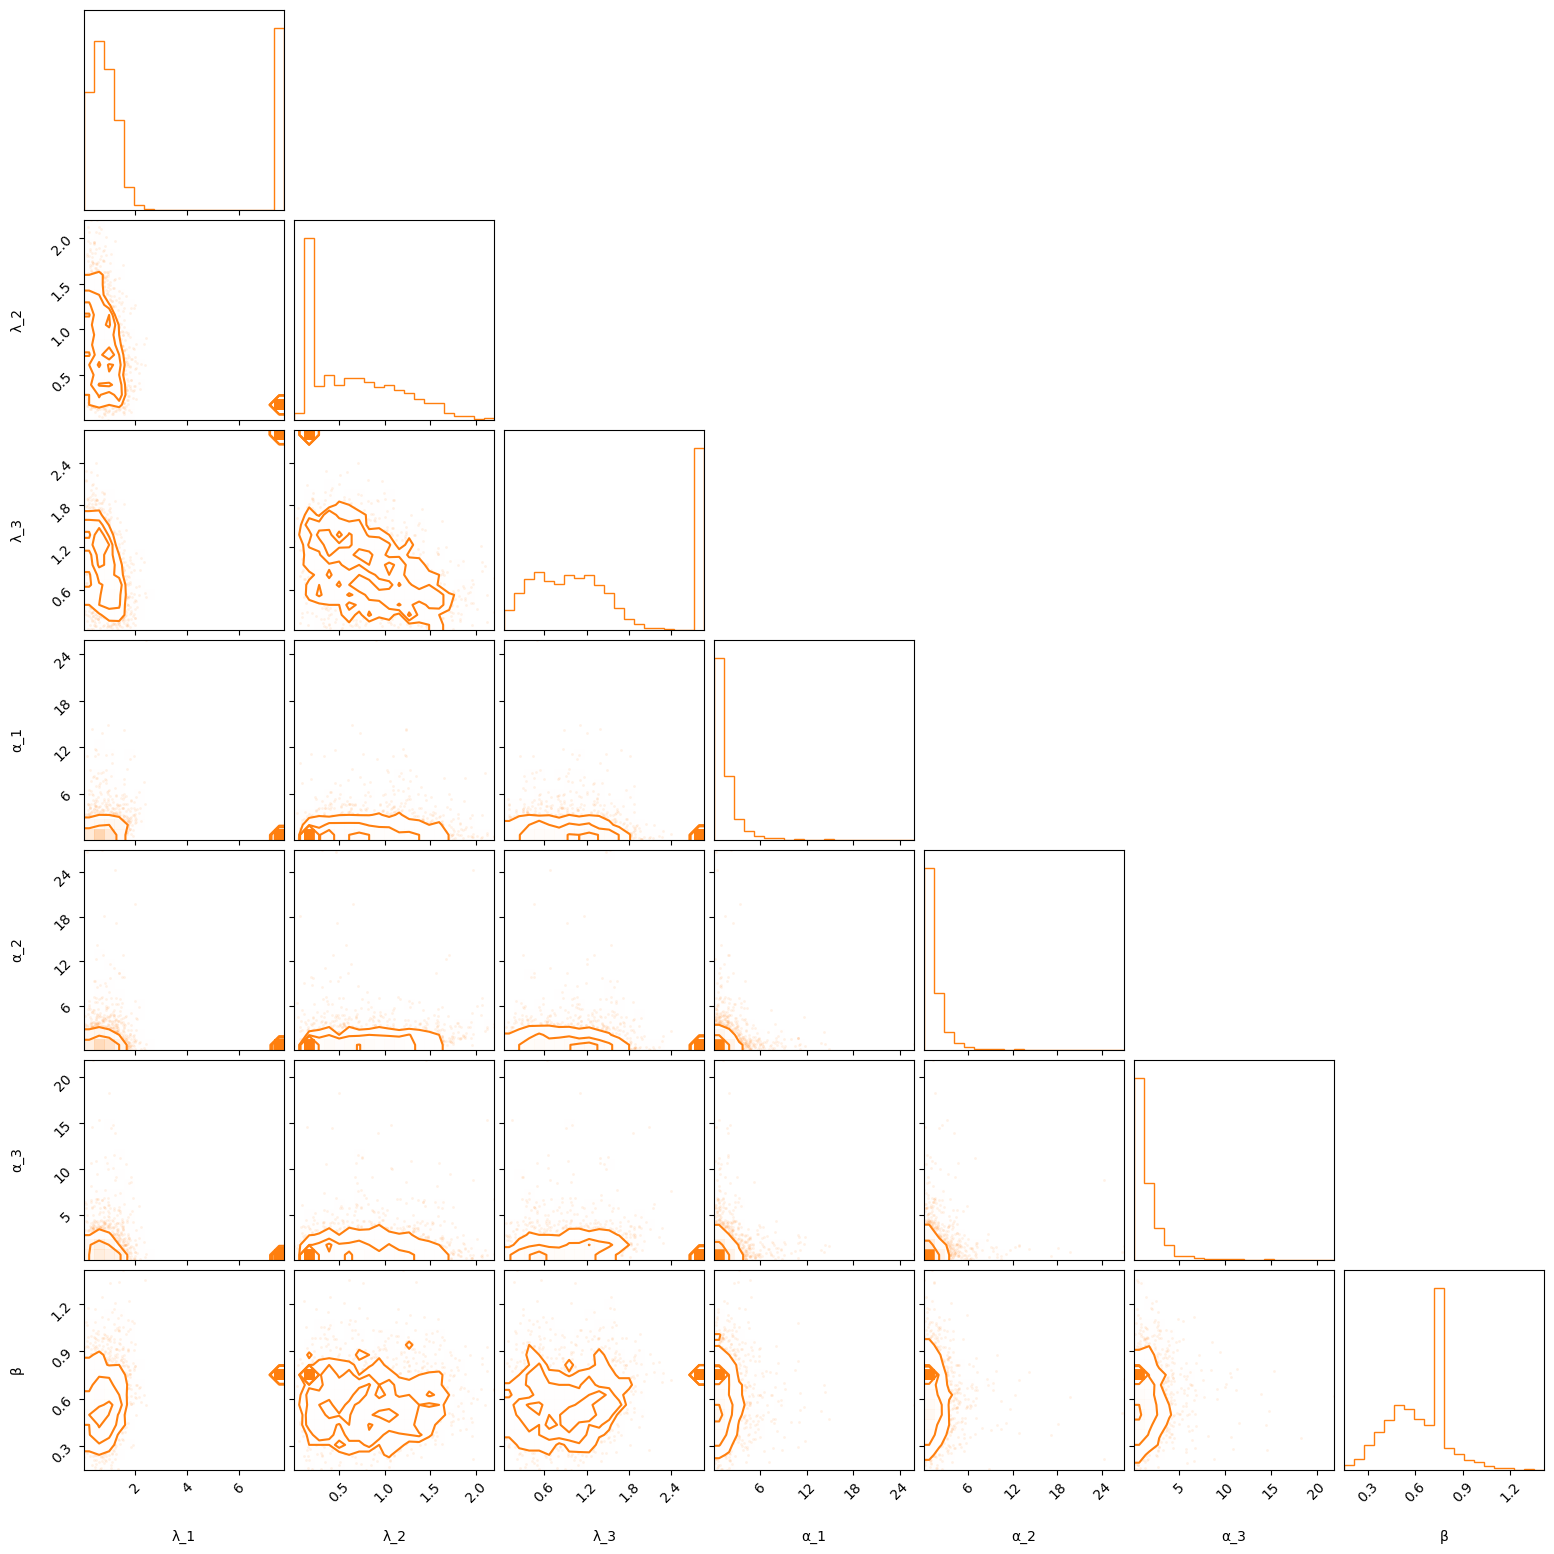

local_gaussian_ii
0.05


Sampling stage: Adaptive warm up [03:25] > Main non-adaptive [02:43]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/systems.py:257: RuntimeWarning: overflow encountered in matmul
  return 0.5 * state.mom @ self.dh2_dmom(state)


Chain 1/4: 100%|██████████|500/500 [00:01<00:00, 394.22it/s, n_step=1.00, accept_stat=0.00]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|500/500 [00:54<00:00, 9.23it/s, n_step=510., accept_stat=0.928]

Chain 3/4: 100%|██████████|500/500 [00:54<00:00, 9.20it/s, n_step=511., accept_stat=0.937]

Chain 4/4: 100%|██████████|500/500 [00:54<00:00, 9.25it/s, n_step=510., accept_stat=0.935]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ_1,2.605,3.068,0.217,7.872,1.510,1.164,7.0,1518.0,1.54
λ_2,0.670,0.488,0.096,1.546,0.143,0.104,10.0,5.0,1.32
λ_3,1.361,0.954,0.245,2.872,0.435,0.352,7.0,1499.0,1.53
α_1,1.284,1.626,0.052,3.835,0.303,0.217,11.0,5.0,1.29
α_2,1.491,1.555,0.060,3.536,0.043,0.032,1613.0,1339.0,1.52
α_3,1.402,1.407,0.053,3.684,0.217,0.155,36.0,1091.0,1.08
β,0.601,0.190,0.235,0.848,0.052,0.038,17.0,1069.0,1.17


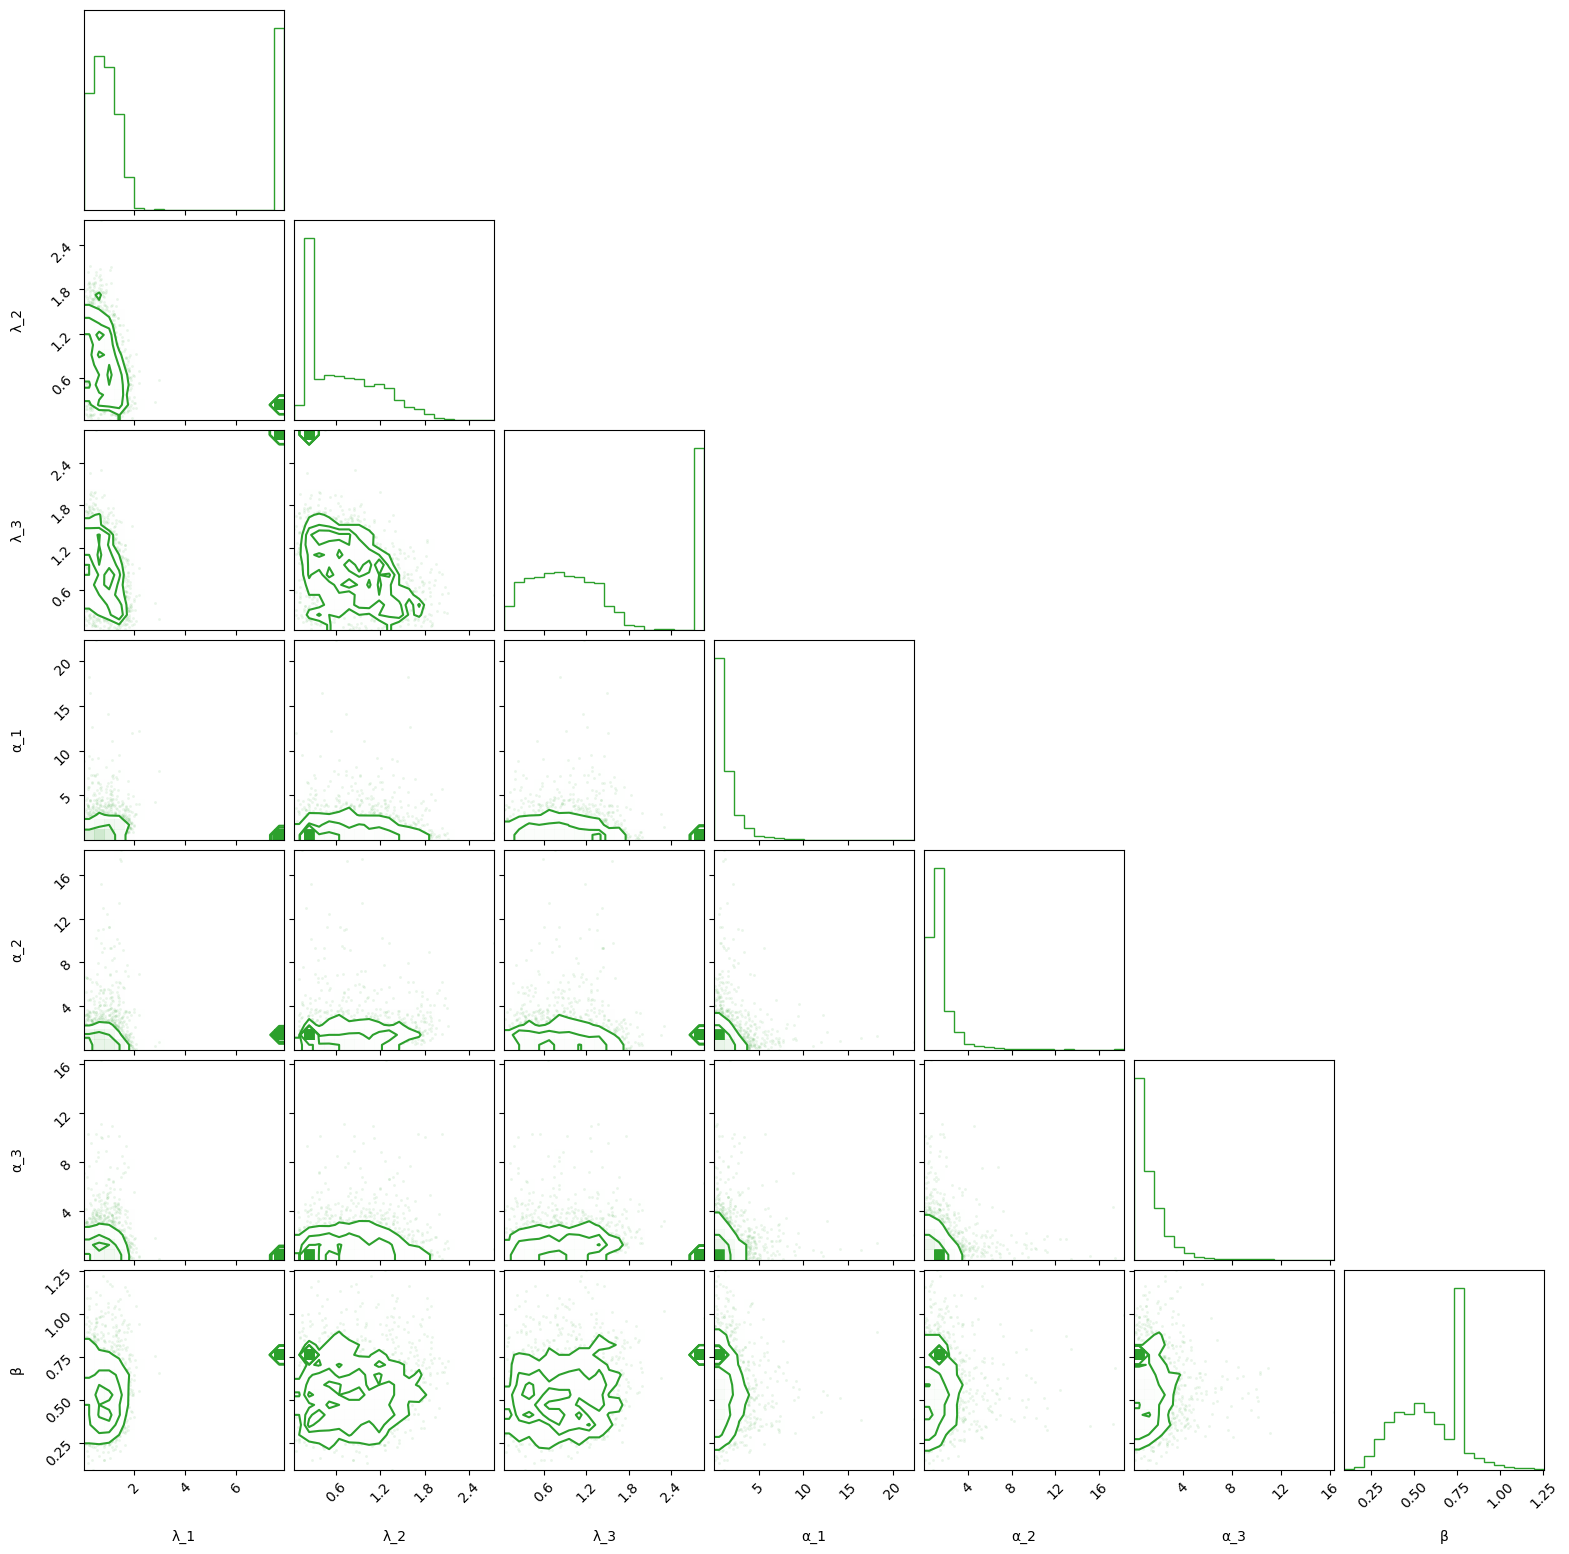

euler_maruyama
0.025


Sampling stage: Adaptive warm up [02:59] > Main non-adaptive [02:23]

Chain 1/4: 100%|██████████|500/500 [00:01<00:00, 398.73it/s, n_step=1.00, accept_stat=0.00]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)
/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/systems.py:257: RuntimeWarning: overflow encountered in matmul
  return 0.5 * state.mom @ self.dh2_dmom(state)


Chain 2/4: 100%|██████████|500/500 [00:47<00:00, 10.61it/s, n_step=511., accept_stat=0.928]

Chain 3/4: 100%|██████████|500/500 [00:47<00:00, 10.52it/s, n_step=510., accept_stat=0.935]

Chain 4/4: 100%|██████████|500/500 [00:47<00:00, 10.43it/s, n_step=511., accept_stat=0.917]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ_1,2.602,3.111,0.240,7.949,1.533,1.180,7.0,1065.0,1.53
λ_2,0.699,0.511,0.104,1.615,0.153,0.111,11.0,5.0,1.30
λ_3,1.381,0.950,0.258,2.875,0.432,0.349,7.0,1961.0,1.53
α_1,1.273,1.590,0.053,3.795,0.301,0.215,11.0,5.0,1.29
α_2,1.560,1.476,0.059,4.132,0.041,0.029,1548.0,1448.0,1.52
α_3,1.431,1.659,0.074,3.764,0.209,0.149,40.0,1334.0,1.07
β,0.608,0.194,0.236,0.888,0.048,0.035,20.0,1025.0,1.15


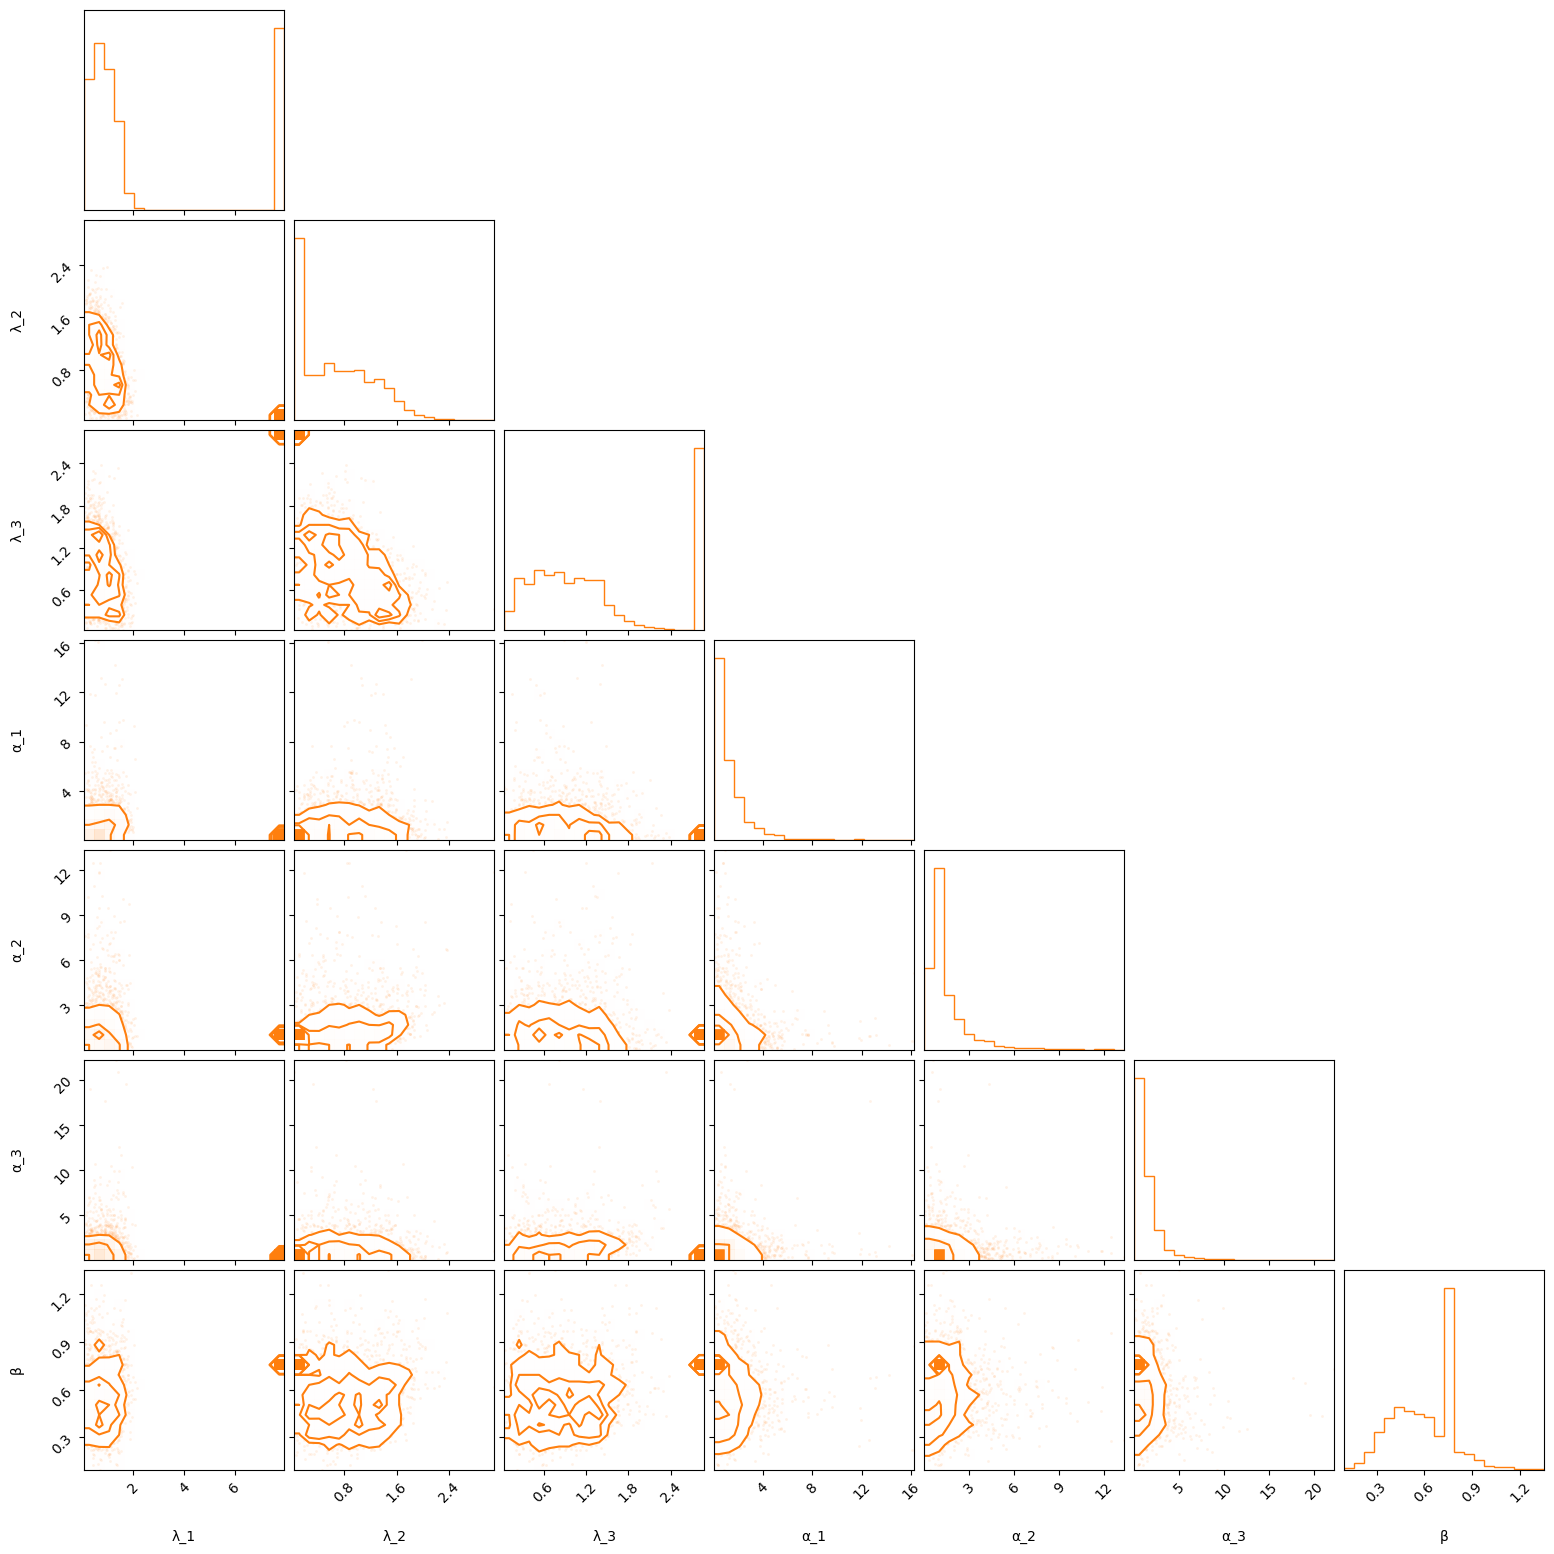

local_gaussian_ii
0.025


Sampling stage: Adaptive warm up [03:54] > Main non-adaptive [02:56]

Chain 1/4: 100%|██████████|500/500 [00:44<00:00, 11.28it/s, n_step=254., accept_stat=0.841]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|500/500 [00:43<00:00, 11.40it/s, n_step=253., accept_stat=0.841]

Chain 3/4: 100%|██████████|500/500 [00:44<00:00, 11.34it/s, n_step=254., accept_stat=0.827]

Chain 4/4: 100%|██████████|500/500 [00:44<00:00, 11.25it/s, n_step=254., accept_stat=0.850]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ_1,0.853,0.438,0.104,1.564,0.025,0.018,321.0,832.0,1.01
λ_2,0.832,0.447,0.073,1.579,0.025,0.018,343.0,838.0,1.01
λ_3,0.888,0.464,0.089,1.638,0.027,0.019,297.0,782.0,1.01
α_1,1.567,1.788,0.098,4.067,0.049,0.035,891.0,1478.0,1.00
α_2,1.739,1.851,0.039,4.540,0.061,0.043,864.0,1344.0,1.00
α_3,1.758,2.137,0.023,4.419,0.074,0.052,814.0,1015.0,1.01
β,0.516,0.176,0.231,0.849,0.005,0.004,1147.0,1056.0,1.00


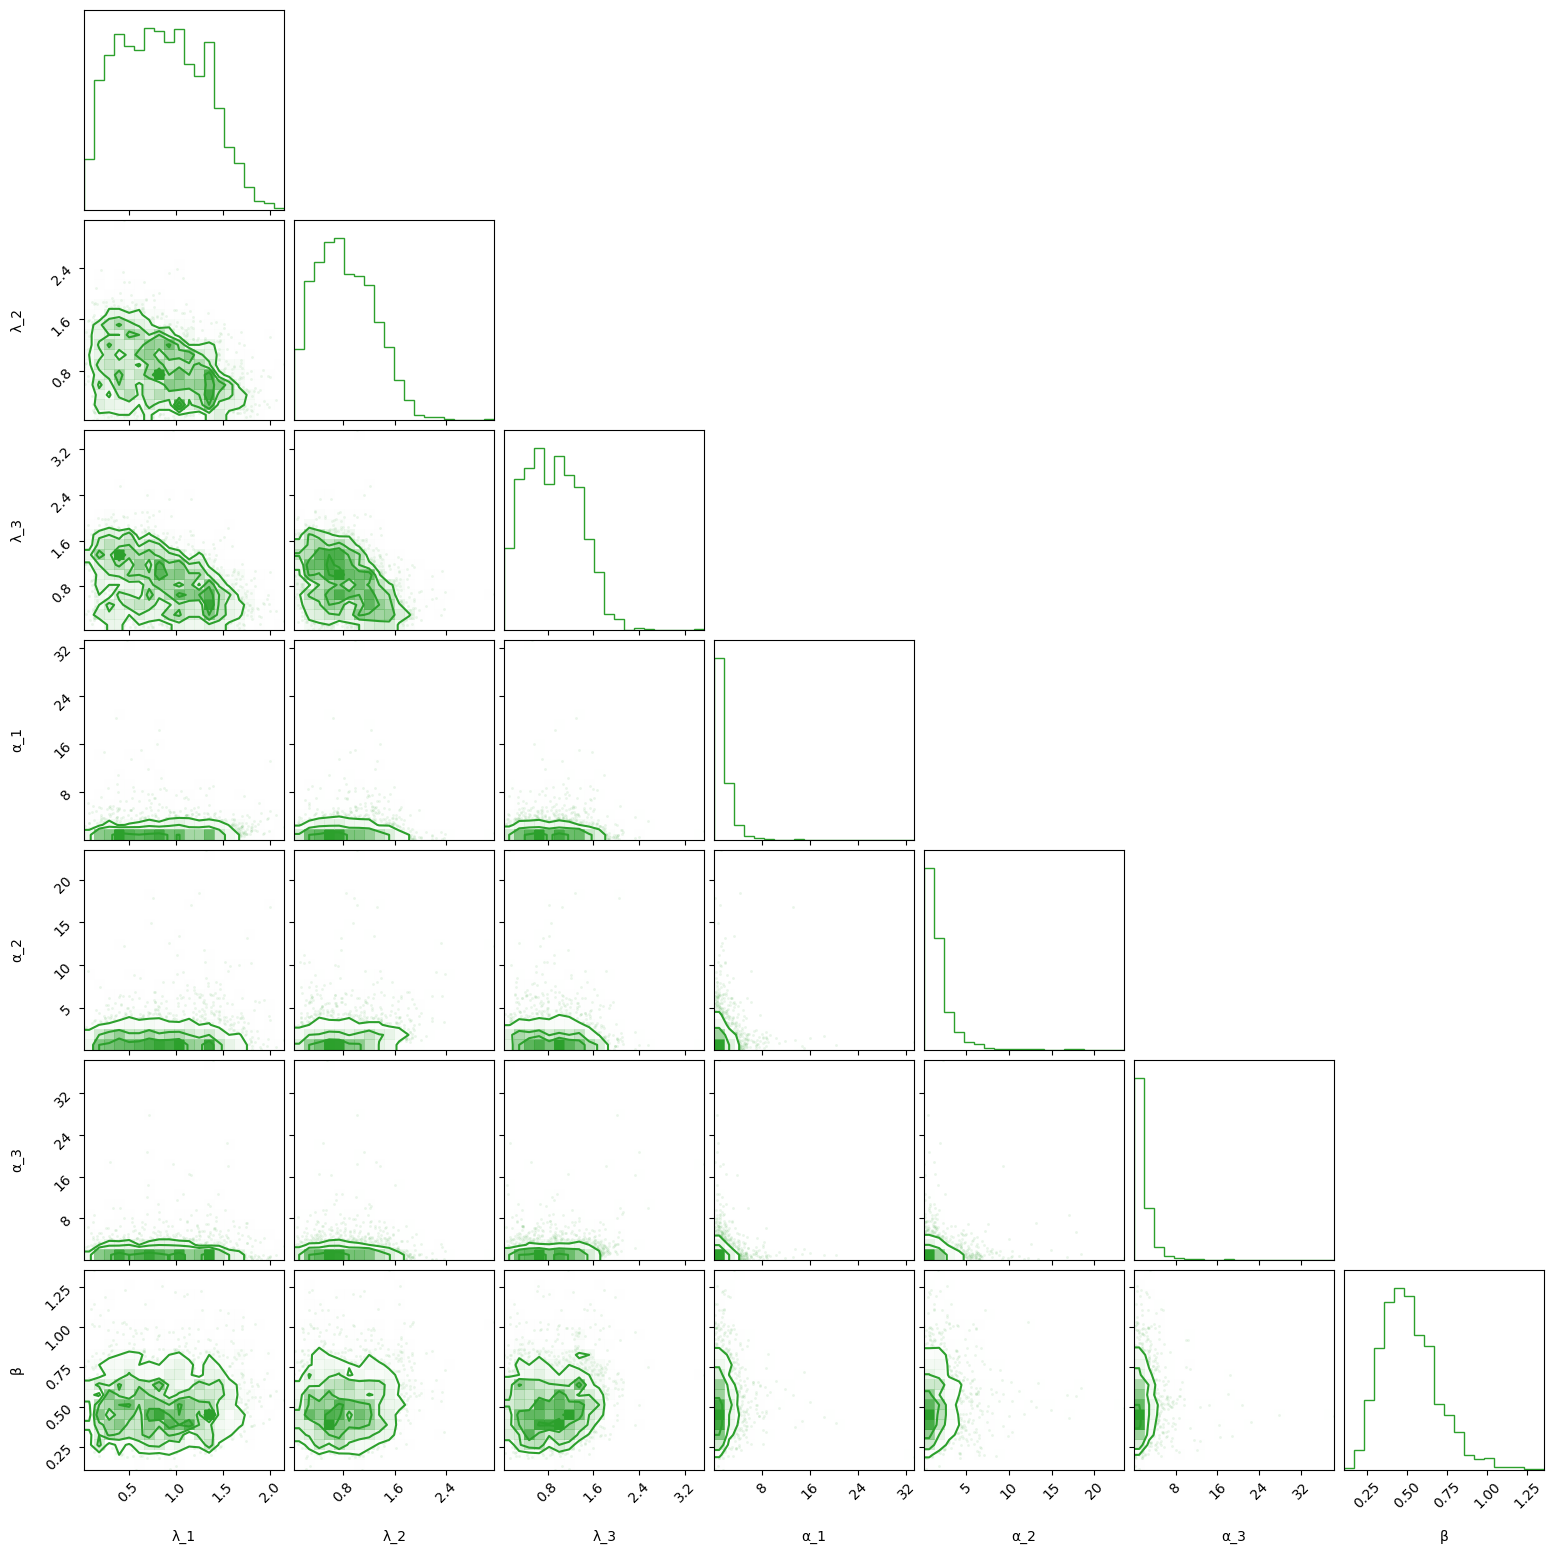

euler_maruyama
0.01


Sampling stage: Adaptive warm up [03:52] > Main non-adaptive [02:52]

Chain 1/4: 100%|██████████|500/500 [00:42<00:00, 11.70it/s, n_step=255., accept_stat=0.854]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|500/500 [00:43<00:00, 11.58it/s, n_step=253., accept_stat=0.848]

Chain 3/4: 100%|██████████|500/500 [00:43<00:00, 11.52it/s, n_step=254., accept_stat=0.835]

Chain 4/4: 100%|██████████|500/500 [00:43<00:00, 11.59it/s, n_step=255., accept_stat=0.859]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ_1,0.852,0.459,0.097,1.614,0.030,0.021,250.0,628.0,1.01
λ_2,0.845,0.446,0.094,1.580,0.025,0.018,334.0,978.0,1.00
λ_3,0.878,0.460,0.096,1.647,0.028,0.019,299.0,714.0,1.02
α_1,1.741,2.127,0.049,4.396,0.056,0.040,857.0,1444.0,1.01
α_2,1.539,1.607,0.048,3.838,0.044,0.031,885.0,1104.0,1.00
α_3,1.648,1.797,0.040,4.227,0.054,0.038,742.0,1280.0,1.00
β,0.520,0.177,0.230,0.861,0.005,0.004,1195.0,1223.0,1.00


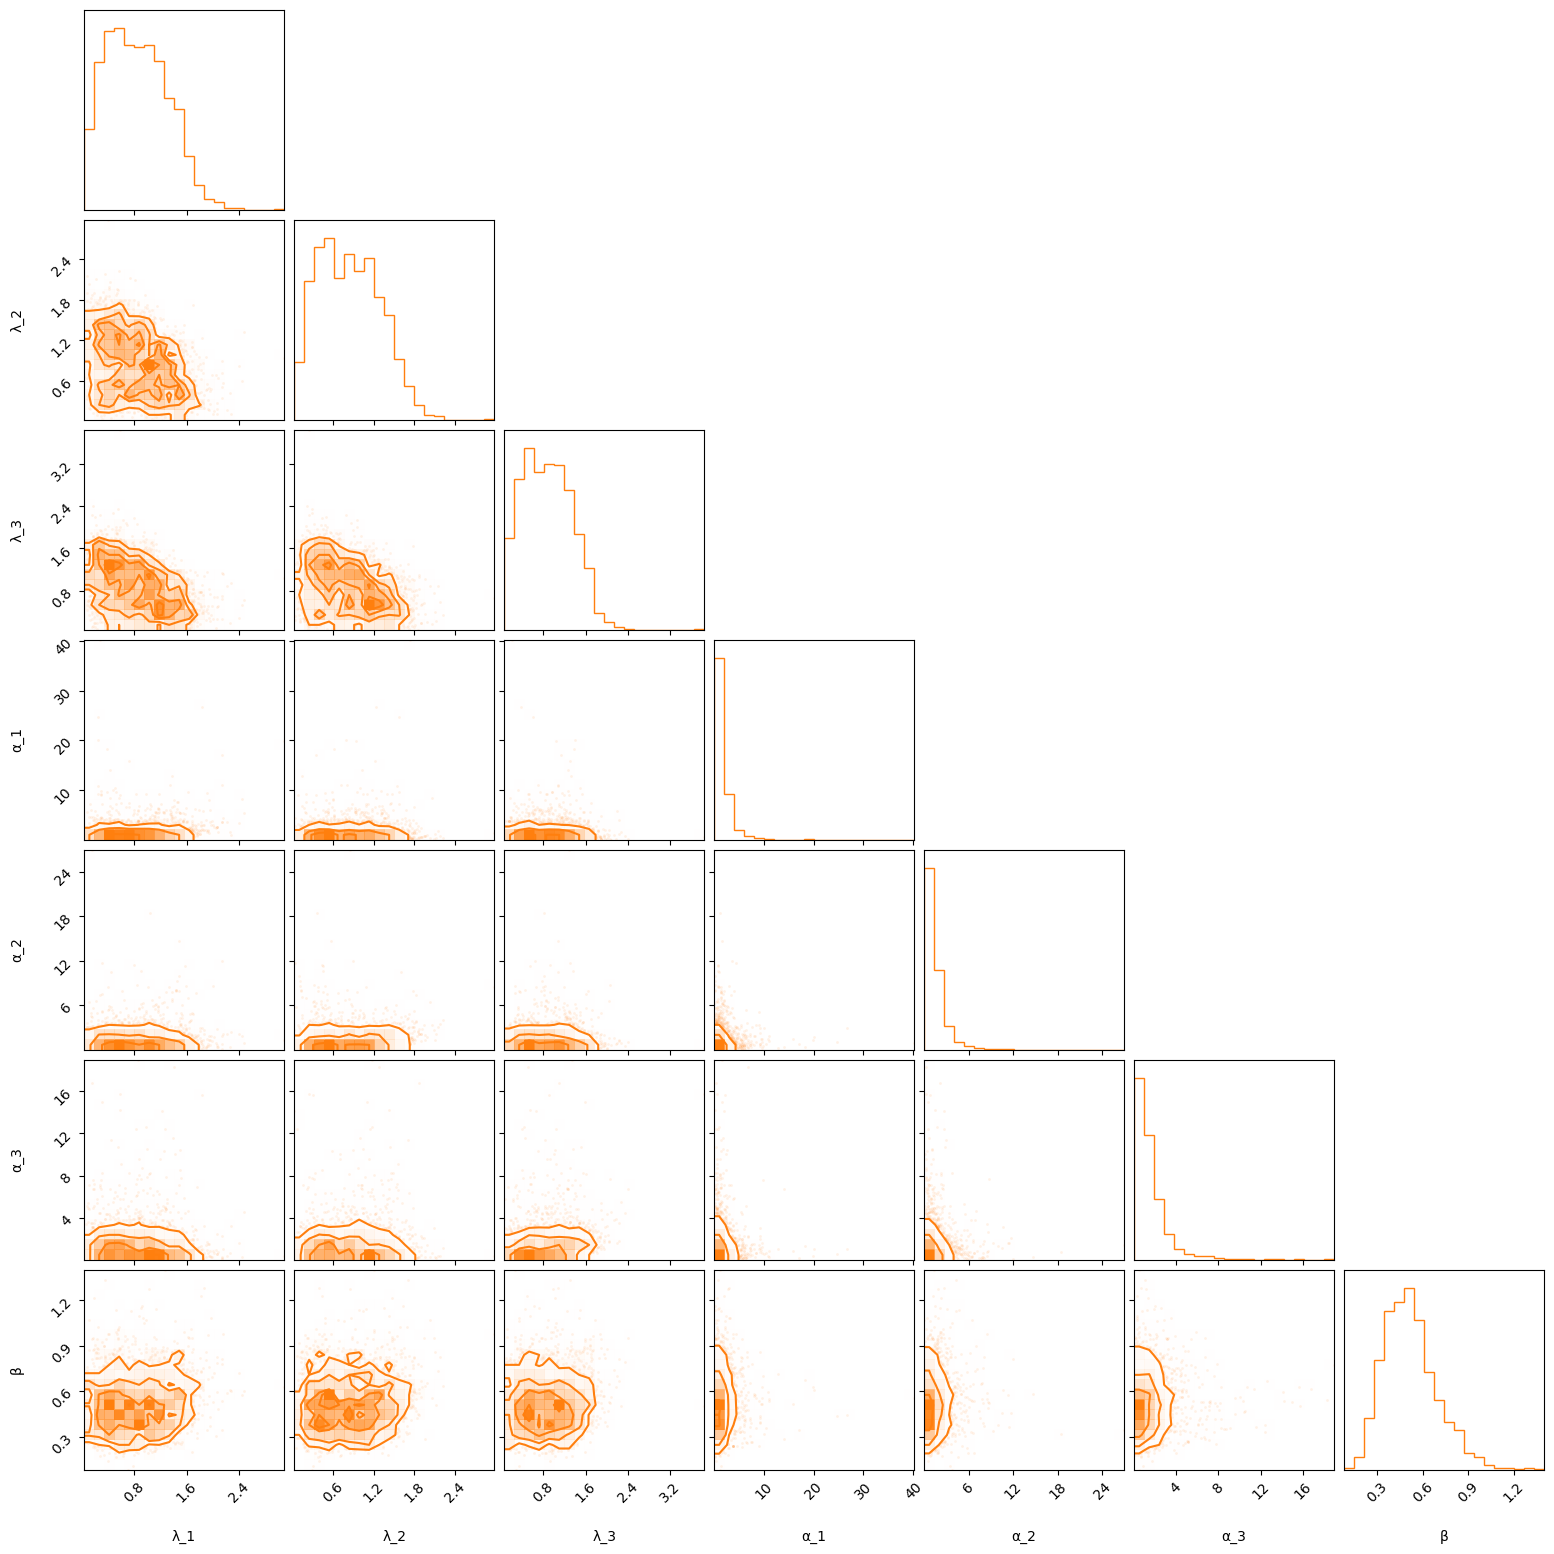

local_gaussian_ii
0.01


Sampling stage: Adaptive warm up [08:09] > Main non-adaptive [06:01]

Chain 1/4: 100%|██████████|500/500 [01:30<00:00, 5.54it/s, n_step=255., accept_stat=0.868]

Chain 2/4: 100%|██████████|500/500 [01:29<00:00, 5.56it/s, n_step=255., accept_stat=0.860]

Chain 3/4: 100%|██████████|500/500 [01:31<00:00, 5.48it/s, n_step=255., accept_stat=0.866]

Chain 4/4: 100%|██████████|500/500 [01:29<00:00, 5.58it/s, n_step=253., accept_stat=0.833]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ_1,0.862,0.449,0.116,1.624,0.028,0.020,277.0,975.0,1.01
λ_2,0.872,0.455,0.071,1.608,0.024,0.017,385.0,981.0,1.00
λ_3,0.845,0.453,0.078,1.596,0.026,0.019,329.0,861.0,1.00
α_1,1.574,1.645,0.085,4.279,0.049,0.034,775.0,1201.0,1.00
α_2,1.702,1.963,0.037,4.186,0.052,0.036,915.0,1308.0,1.00
α_3,1.780,2.078,0.036,4.620,0.061,0.043,851.0,1057.0,1.00
β,0.518,0.172,0.210,0.830,0.005,0.003,1346.0,1482.0,1.00


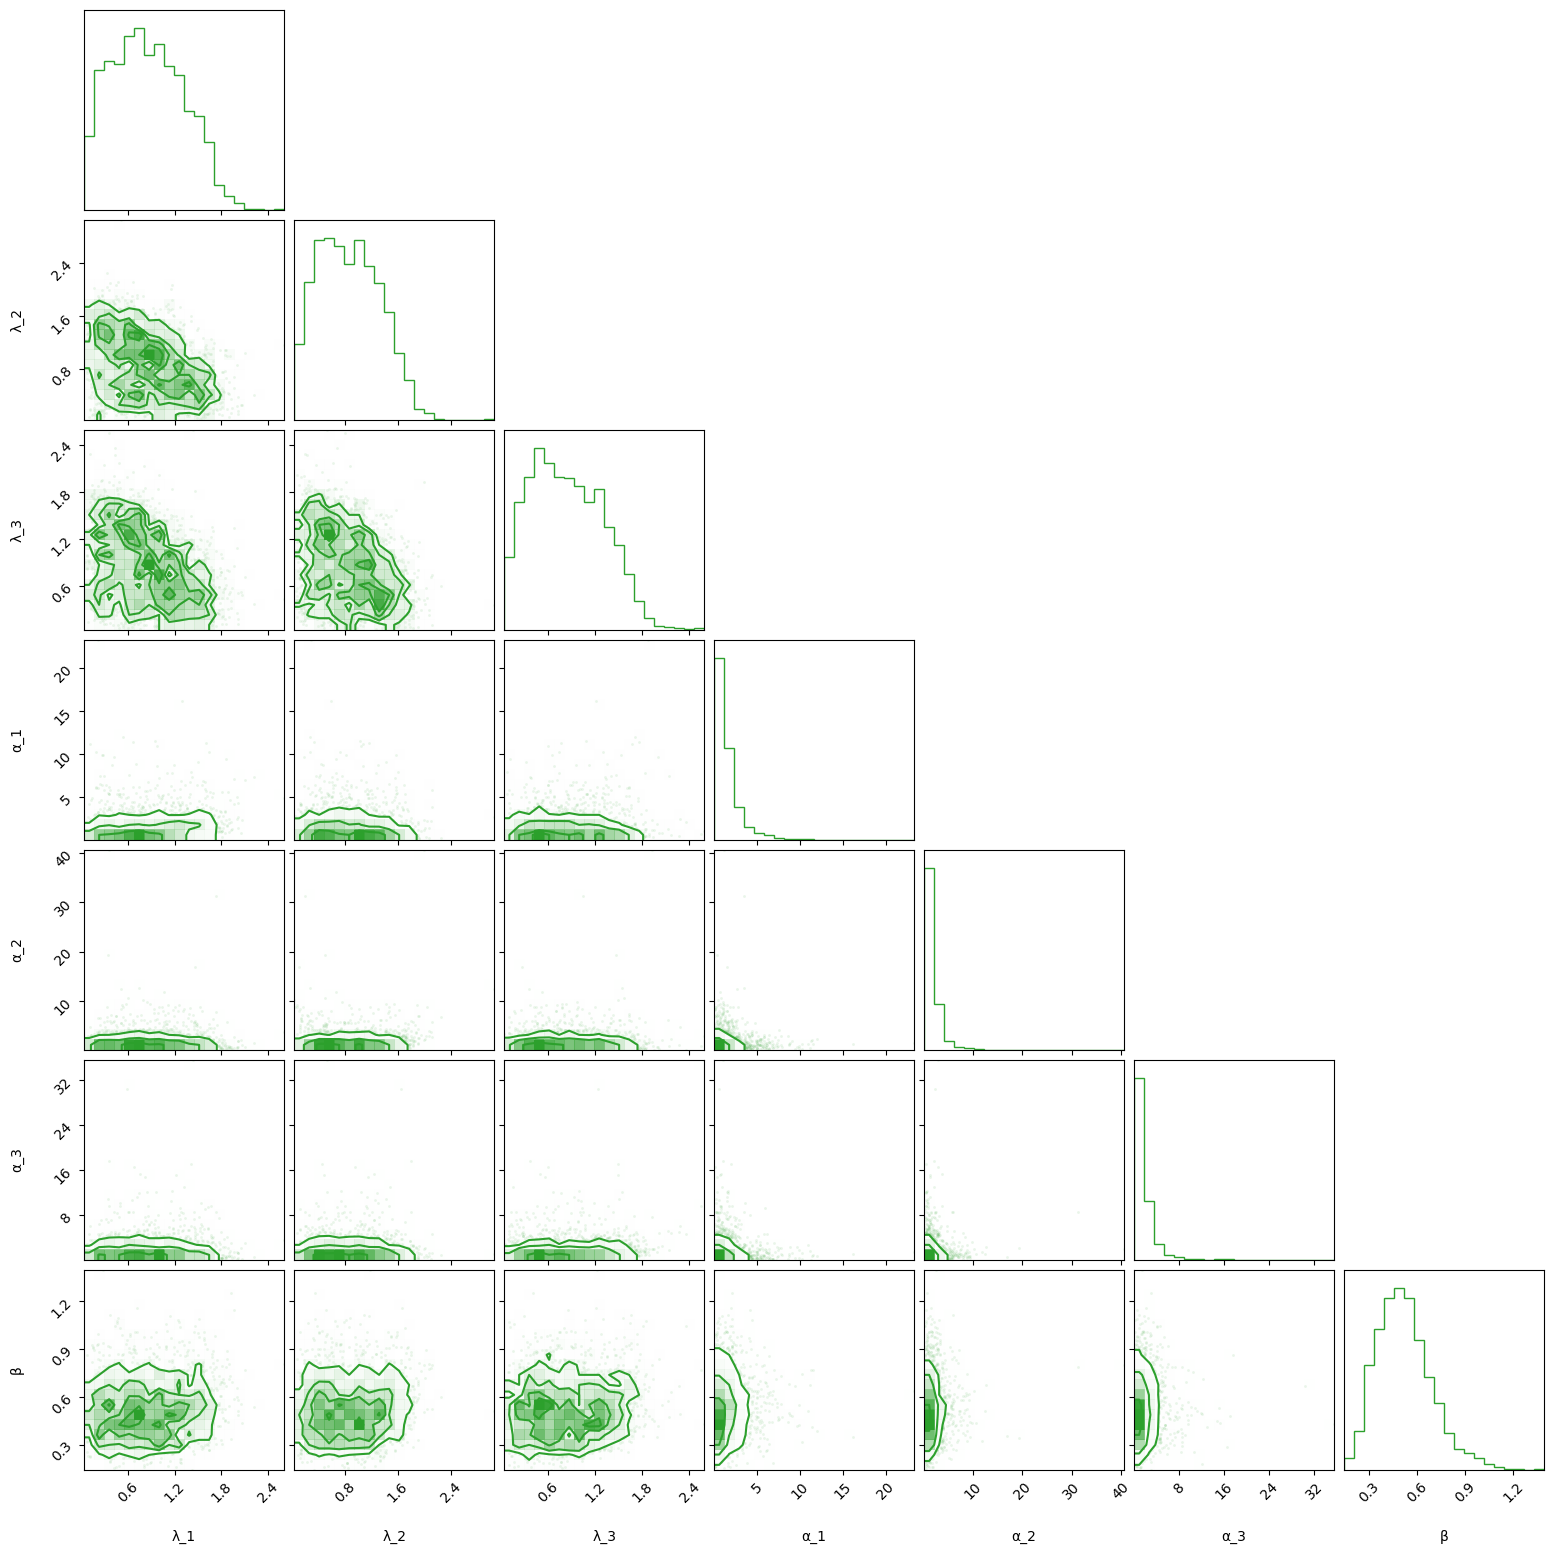

In [16]:
n_chain = 4
n_warm_up_iter = 500
n_main_iter = 500
dt_inference_seq = np.array([0.05, 0.025, 0.01]) 
trace = [[] for i in range(2)]

for dt_inference in dt_inference_seq:
    color = 1
    for key, generate_x_seq in generate_x_seq_functions.items():
        print(key)
        print(dt_inference)
        t_seq_inference = t_seq_simulation[::int(dt_inference / dt_simulation)]
        obs_time_indices = slice(0, None, int(dt_observation / dt_inference))

        common_kwargs = {
            "generate_θ": generate_θ,
            "generate_x_0": generate_x_0,
            "obs_func": obs_func,
            "t_seq": t_seq_inference,
            "dim_u": dim_u,
            "dim_v_0": dim_v_0,
            "obs_noise_std": 0.3,
            "obs_time_indices": obs_time_indices,
            "y_obs": y_obs
        }

        posterior_density_functions = get_posterior_density_functions(
            generate_x_seq=generate_x_seq, **common_kwargs
        )
        dim_q = (
            common_kwargs["dim_u"] 
            + common_kwargs["dim_v_0"]
            + step_funcs_and_dim_n[key][1] * (len(t_seq_inference) - 1)
        )
        rng = np.random.default_rng(20230227)
        system = mici.systems.EuclideanMetricSystem(**posterior_density_functions)
        integrator = mici.integrators.LeapfrogIntegrator(system)
        sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
        adapters = [
            mici.adapters.DualAveragingStepSizeAdapter(0.8),
        ]
        init_states = []
        while len(init_states) < n_chain:
            q = rng.standard_normal(dim_q)
            g, v = system._grad_neg_log_dens(q)
            if not (np.any(np.isnan(g)) or np.isnan(v)):
                init_states.append(q)
        final_states, traces, stats = sampler.sample_chains_with_adaptive_warm_up(
            n_warm_up_iter=n_warm_up_iter,
            n_main_iter=n_main_iter,
            init_states=init_states,
            monitor_stats=["n_step", "accept_stat"],
            trace_funcs=[trace_func],
            adapters=adapters,
        )
        summary = arviz.summary(traces)
        fig = corner.corner(traces, 
            color=f'C{color}',
        )
        display(summary)
        display(fig)
        plt.close(fig)
        trace[color-1].append(traces)
        color += 1


euler_maruyama
0.005


Sampling stage: Adaptive warm up [06:45] > Main non-adaptive [04:51]

Chain 1/4: 100%|██████████|500/500 [01:13<00:00, 6.83it/s, n_step=254., accept_stat=0.846]

Chain 2/4: 100%|██████████|500/500 [01:12<00:00, 6.87it/s, n_step=254., accept_stat=0.825]

Chain 3/4: 100%|██████████|500/500 [01:13<00:00, 6.84it/s, n_step=255., accept_stat=0.853]

Chain 4/4: 100%|██████████|500/500 [01:12<00:00, 6.88it/s, n_step=254., accept_stat=0.847]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ_1,0.897,0.475,0.100,1.677,0.028,0.020,293.0,948.0,1.01
λ_2,0.849,0.448,0.088,1.578,0.027,0.019,296.0,752.0,1.01
λ_3,0.844,0.450,0.092,1.594,0.024,0.017,367.0,937.0,1.01
α_1,1.731,1.777,0.075,4.399,0.050,0.036,768.0,1213.0,1.00
α_2,1.626,1.884,0.038,4.098,0.055,0.039,1011.0,1414.0,1.00
α_3,1.767,2.092,0.047,4.636,0.066,0.047,907.0,1399.0,1.00
β,0.520,0.178,0.220,0.849,0.005,0.003,1450.0,1658.0,1.00


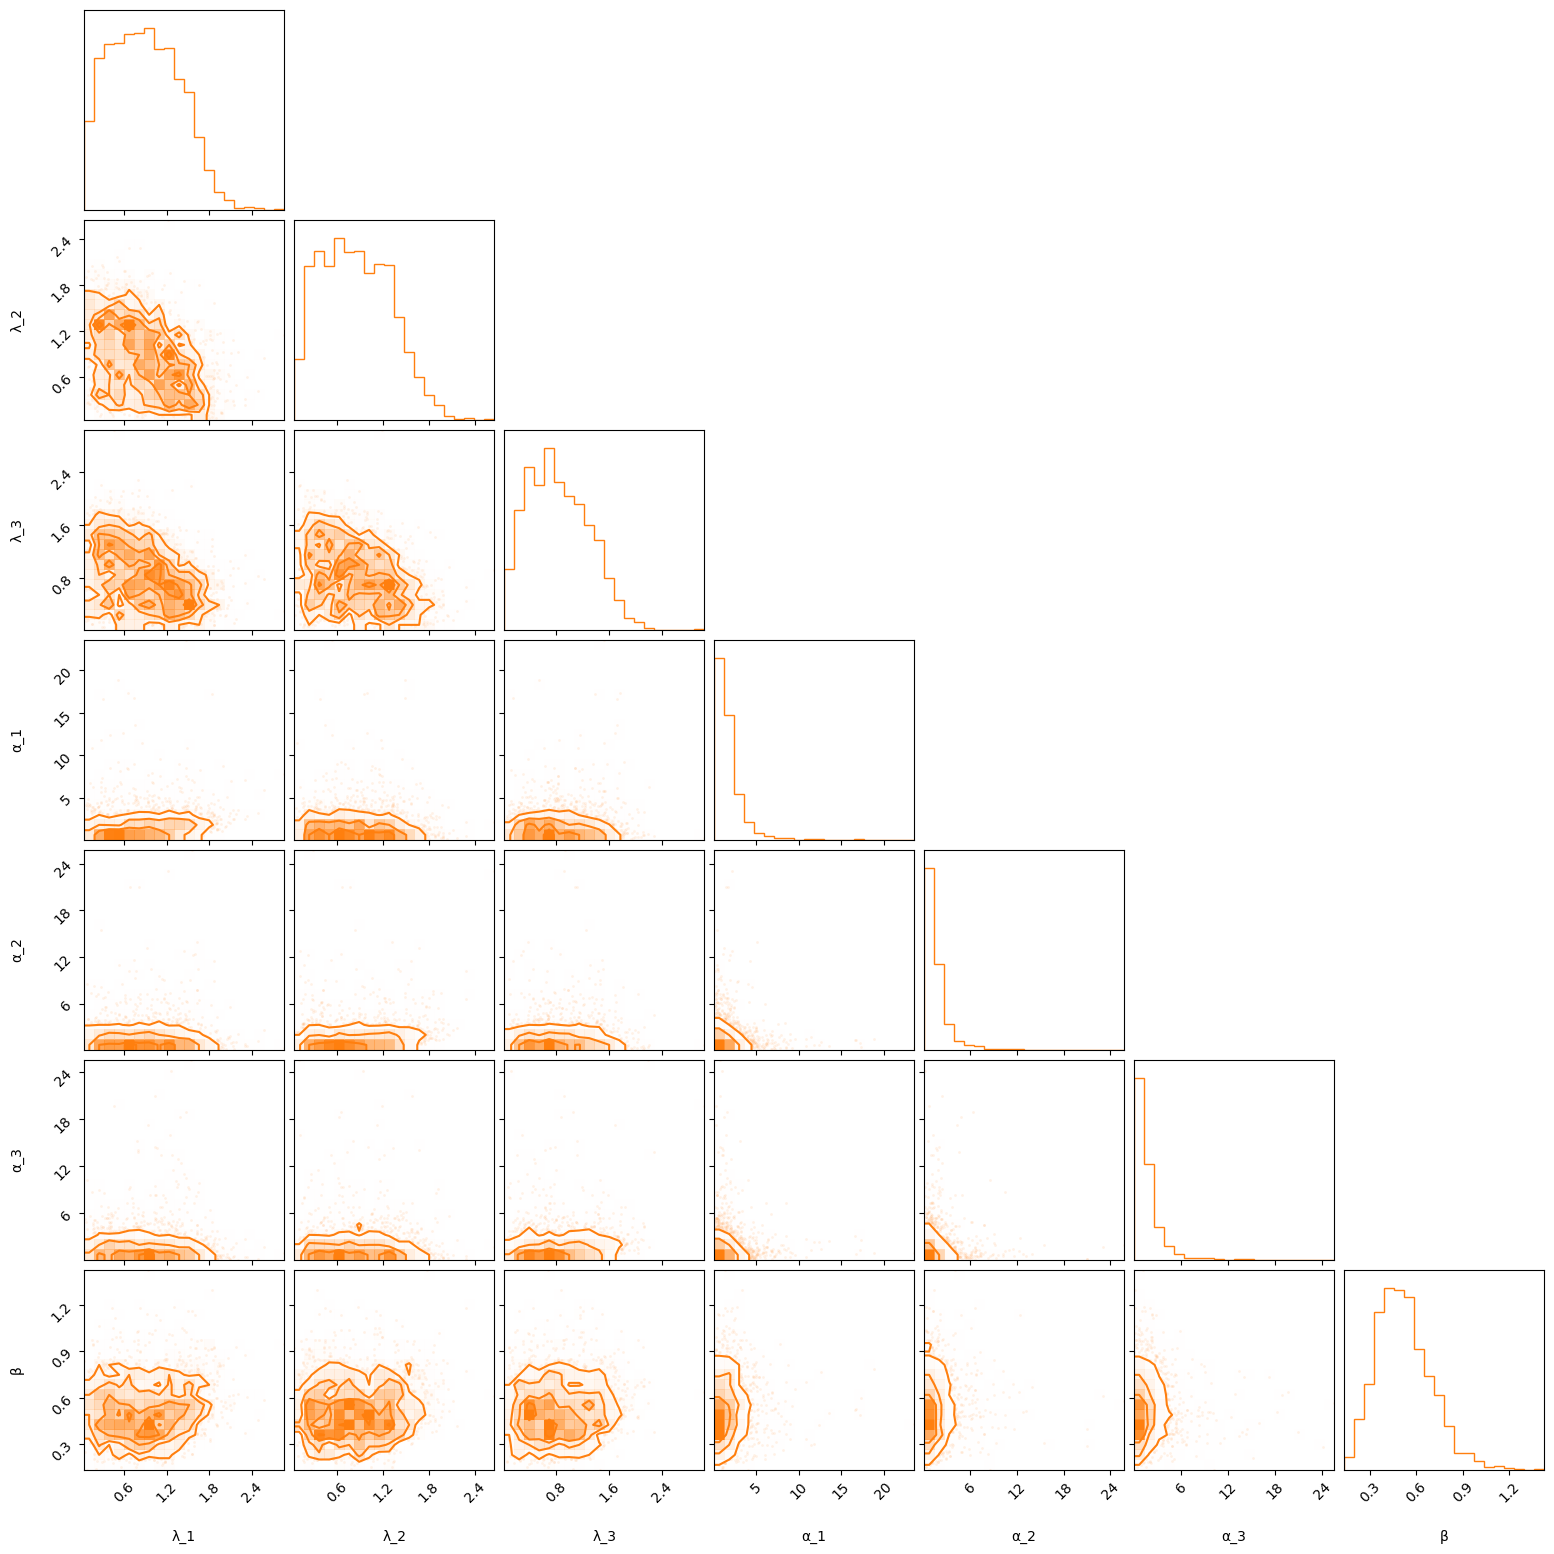

local_gaussian_ii
0.005


Sampling stage: Adaptive warm up [15:54] > Main non-adaptive [11:47]

Chain 1/4: 100%|██████████|500/500 [02:56<00:00, 2.84it/s, n_step=255., accept_stat=0.815]

Chain 2/4: 100%|██████████|500/500 [03:00<00:00, 2.76it/s, n_step=254., accept_stat=0.843]

Chain 3/4: 100%|██████████|500/500 [02:54<00:00, 2.86it/s, n_step=254., accept_stat=0.826]

Chain 4/4: 100%|██████████|500/500 [02:55<00:00, 2.85it/s, n_step=253., accept_stat=0.829]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ_1,0.876,0.450,0.101,1.606,0.023,0.016,398.0,1145.0,1.01
λ_2,0.841,0.458,0.101,1.634,0.027,0.019,317.0,875.0,1.00
λ_3,0.866,0.453,0.109,1.638,0.025,0.017,369.0,1012.0,1.01
α_1,1.711,2.069,0.043,4.409,0.063,0.046,841.0,1123.0,1.00
α_2,1.595,1.642,0.063,4.246,0.048,0.034,840.0,1235.0,1.00
α_3,1.586,1.524,0.028,3.878,0.044,0.031,748.0,1091.0,1.01
β,0.511,0.178,0.197,0.824,0.005,0.004,1228.0,1439.0,1.00


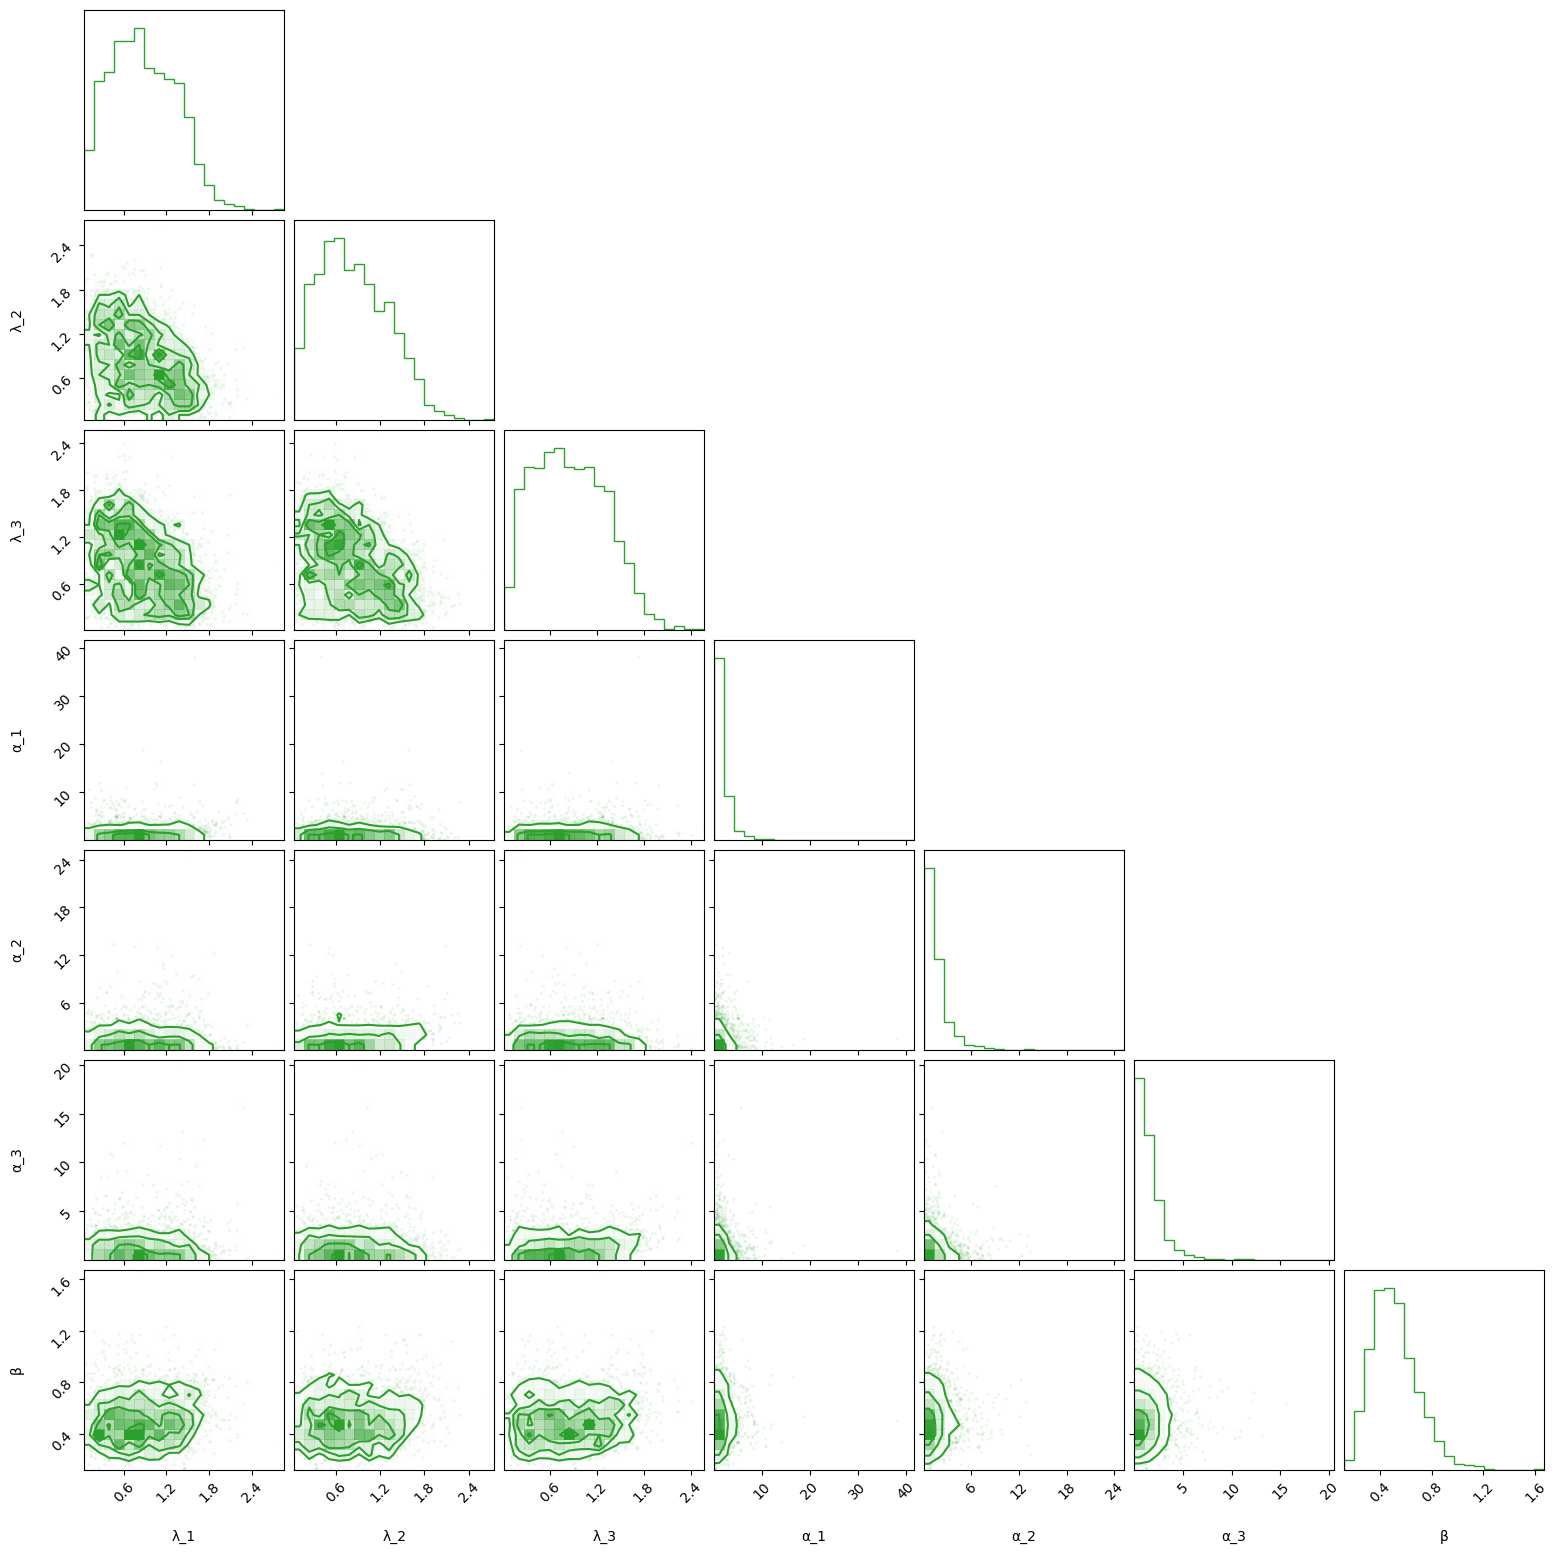

In [24]:
n_chain = 4
n_warm_up_iter = 500
n_main_iter = 500
dt_inference_seq = np.array([0.005]) 
trace = [[] for i in range(2)]

for dt_inference in dt_inference_seq:
    color = 1
    for key, generate_x_seq in generate_x_seq_functions.items():
        print(key)
        print(dt_inference)
        t_seq_inference = t_seq_simulation[::int(dt_inference / dt_simulation)]
        obs_time_indices = slice(0, None, int(dt_observation / dt_inference))

        common_kwargs = {
            "generate_θ": generate_θ,
            "generate_x_0": generate_x_0,
            "obs_func": obs_func,
            "t_seq": t_seq_inference,
            "dim_u": dim_u,
            "dim_v_0": dim_v_0,
            "obs_noise_std": 0.3,
            "obs_time_indices": obs_time_indices,
            "y_obs": y_obs
        }

        posterior_density_functions = get_posterior_density_functions(
            generate_x_seq=generate_x_seq, **common_kwargs
        )
        dim_q = (
            common_kwargs["dim_u"] 
            + common_kwargs["dim_v_0"]
            + step_funcs_and_dim_n[key][1] * (len(t_seq_inference) - 1)
        )
        rng = np.random.default_rng(20230227)
        system = mici.systems.EuclideanMetricSystem(**posterior_density_functions)
        integrator = mici.integrators.LeapfrogIntegrator(system)
        sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
        adapters = [
            mici.adapters.DualAveragingStepSizeAdapter(0.8),
        ]
        init_states = []
        while len(init_states) < n_chain:
            q = rng.standard_normal(dim_q)
            g, v = system._grad_neg_log_dens(q)
            if not (np.any(np.isnan(g)) or np.isnan(v)):
                init_states.append(q)
        final_states, traces, stats = sampler.sample_chains_with_adaptive_warm_up(
            n_warm_up_iter=n_warm_up_iter,
            n_main_iter=n_main_iter,
            init_states=init_states,
            monitor_stats=["n_step", "accept_stat"],
            trace_funcs=[trace_func],
            adapters=adapters,
        )
        summary = arviz.summary(traces)
        fig = corner.corner(traces, 
            color=f'C{color}',
        )
        display(summary)
        display(fig)
        plt.close(fig)
        trace[color-1].append(traces)
        color += 1


In [ ]:
for color in range(2):
    fig = corner.corner(trace[color][1], 
                bins=20,
                truths= [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.500],
                color=f'C{color}'
            )
    display(fig)
    plt.close(fig)